场景：检测自然环境中的行人

识别：就是对物体进行分类
检测：就是回答是否有人
流程->检测->识别

思想：
    大多数检测算法的核心思想是把图像拆分成很多小的块，然后将每个图像块分类为包含行人或者不包含行人两类
     算法步骤为 Hog特征+SVM 检测是否有行人

步骤：
    1.建立包含行人的一个图像数据库。这将作为我们的正数据样本
    2.建立不包含行人的一个图像数据库。这将作为我们的负数据样本.
    3.在数据集上训练一个SVM
    4.将SVM应用于每个可能的测试图像块，以确定整个图像是否包含一个行人.

数据集介绍
该数据集一共提供了924张包含行人的彩色图像,
每张图像都缩放为64×128像素并对齐，这样人的身体就处在图像的中心位置了
这些图像是在波士顿和剑桥处于不同季节时以及各种不同光照情况下拍摄的
用OpenCV读取图像，并将图像的RGB版本传递给matplotlib来可视化一些示例图像

In [481]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

(5, 128, 64)

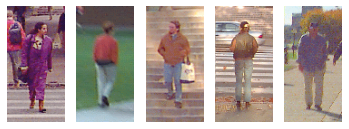

In [482]:
"查看下数据库的图片,随机抽取5张图片"
people = []
for i,data in enumerate(np.random.randint(1,900,5)):
    filename = f"data/pedestrians128x64/per{data:05d}.ppm"
    img = cv2.imread(filename)
    people.append(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
    plt.subplot(1,5,i+1)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.axis("off") #关闭坐标轴显示
people = np.array(people)
people.shape#(5, 128, 64) gray类型

Hog 方向梯度直方图（Histogram of Oriented Gradient, HOG)
Hog特征常用来结合SVM分类器 来达到检测目的
作用：用来进行物体检测的特征描述子
原理：
    通过计算和统计图像局部区域的梯度方向直方图来构成特征,在一副图像中，局部目标的表象和形状能够被梯度或边缘的方向密度分布很好地描述.
其本质为：梯度的统计信息，而梯度主要存在于边缘的地方.
基本思想：
    边缘方向的分布可以描述图像中物体的局部形状和外观。把图像拆分成小的连通区域，在这些区域内编译梯度方向（或者边缘方向）直方图。然后，描述符是通过连接不同的直方图组合而成的.
优点：
    1.HOG是在图像的局部方格单元上操作，所以它对图像几何的和光学的形变都能保持很好的不变性
    2.在粗的空域抽样、精细 的方向抽样以及较强的局部光学归一化等条件下，只要行人大体上能够保持直立的姿势，可以容许行人有一些细微的肢体动作，这些细微的动作可以被忽略而不影响 检测效果.

Hog中的窗口(win),区块(block),cell
1.win(窗口)：在HOG特征提取时，一个窗口是最小的特征提取单元,类似于深度学习中的卷积.其运算公式一样
    以示例图像为例输入图像(128, 64, 3),win大小为32x32,步长为(8,8),在输入两端各添加P个0,
    那么滑动次数为：列上滑动： (128-32)/8 = 12次,行上滑动 (64-32)/8  = 4
    共滑动得到 12x4 = 48 个窗口

2.block ：
    假设block 设置为 8x8, 步长为(8,8), 此时一个窗口内,有 (32-8)/8  =3,
    行同样如此,共3x3 = 9个block  这张图片共  48x9 = 432个block
3.cell
    这里的cell,可以理解为不可再分的基本单元,cell类似于将block直接分块,
    若cell大小为(4x4) 则一个block 64/16 = 4个cell ,这张图共 48x9x4 = 1728个cell

注意点：
    win可以用padding填充,但是block 和cell ,HOG算法不允许填充.可能存在的问题,设置block和cell有误,无法得到整数,从而产生错误


提取Hog特征的步骤
1.色彩和伽马归一化,
    将整个图像进行规范化（归一化),Gamma归一化
2.计算图像梯度 ,计算图像横坐标和纵坐标方向的梯度,并据此计算每个像素位置的梯度方向值 Sobel
3.构建方向的直方图：
    每个cell中都有一个方向梯度直方图,计算采用加权的方式,权值是根据该像素点的梯度幅度计算出来.
    研究发现，采用无向的梯度和9个直方图通道，能在行人检测试验中取得最佳的效果。
    而在这种情况下方向的范围划分为 180/9 = 20度
    此时,一个cell的维度为  9,一个block的维度为 9 x 4,一个win 的维度为 9x4x9,
    一张图像的维度为9x4x9x48(Gray),9x4x9x48x3(RGB)
4.将细胞单元组合成大的区间
5.收集HOG特征,把提取的HOG特征输入到SVM分类器中，寻找一个最优超平面作为决策函数

opencv中使用cv2.HOGDescriptor访问HOG描述符,正如上面介绍的
他接受一些输入参数,win,block,cell,stride
对于每一个单元格，HOG描述符默认用9个bin计算一个面向梯度的直方图
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels)




0.00087734446

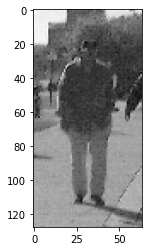

In [483]:
""""""
IMG = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(IMG,cmap= 'gray')
HOG = cv2.HOGDescriptor((64,64),(32,32),(32,32),(16,16),9)
aa_RGB = HOG.compute(img,(64,64))
aa_Gray = HOG.compute(IMG, (64, 64))
'''此时我们衡量一下单通道和三通道得到的HOG矩阵相似度
相似度计算：均方误差、SSIM 结构相似性度量、cosine余弦距离、直方图'''
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(aa_RGB,aa_Gray)
MSE

由上面可知,我们再从一个例子来理解Hog算子
图片(128,64)
winSize (64,64),winStride(64,64),blockSize(32,32)blockStride(32,32)
cellSize(16,16) ,nbin 9
单通道：(128x64x1)
    Win：2个,block：2x4 ,cell ：2x4x4
    bins = 2x4x4x9 = 288  即得到（288,1)
三通道也是如此,通过计算两个Hog矩阵的MSE 发现均方误差仅仅为0.00045,推测cv2中hog计算应该也是先将图片灰度化,然后再处理
不过查看HOGDescription 未发现灰度化函数,但有看到计算梯度值的函数 computeGradient()

In [484]:
'''opencv HOGDescriptor 参数介绍，实测无法使用*args, **kwargs会报错'''
winSize = (20,20)
blockSize = (10,10)
blockStride = (5,5)
cellSize = (10,10)
nbins = 9
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 64
signedGradient = True
cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradient)

<HOGDescriptor 000001F957C40CF0>

In [485]:
#对于纯数字，我们可以通过格式化的方式来补0
sss1 = "%05d" %12

#或者是调用字符串函数 s.zfill（x）
sss2 = "12".zfill(5)

#或者采用format格式
sss3 = f"{1:05d}"
sss1,sss2,sss3

('00012', '00012', '00001')

In [486]:
'''我们可以看到数据集中的人占比相当大，可以采用大的参数设定'''
Hog = cv2.HOGDescriptor((64,64),(32,32),(8,8),(8,8),9)
#block size,blockStride (8,8) nbins 9

'''从900张图片随机选取400张，正样本'''
x_index = []
for i in random.sample(range(1,900),400):
    filename = f"data/pedestrians128x64/per{i:05d}.ppm"
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #减少计算量
    x_index.append(Hog.compute(img,(16,16)))# winStride

x_positive_hog = np.array(x_index,dtype=np.float32)
#(400, 18000, 1) ,每个样本18000个HOG特征
y_positive = np.ones(x_positive_hog.shape[0],dtype=np.int32) #正集

In [487]:
'''SVM的负样本--不是人系列 环境'''
import os
x_neg = []

for file in os.listdir("data/pedestrians_neg"):#50张
    filename = f"data/pedestrians_neg/{file}"
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (512,512))
    "图片随机切割成128，64的图片加入到x——neg中"
    for i in range(8):
        random_x = random.randint(0,380)
        random_y = random.randint(0,440)
        img_random = img[random_x:random_x+128,random_y: random_y + 64]
        x_neg.append(img_random)
'''查看一下分割的图片'''
x_negative = np.array(x_neg)
y_negative = np.zeros(x_negative.shape[0],dtype=np.int32)#400张
'''计算非人的HOG'''
x_neg_hog =np.array(list(map(lambda data:Hog.compute(data,(16,16)),x_negative)),dtype=np.float32)
#map得到一个对象，需要用list转为实例，然后再转为array
environments = [] #随机取5张环境图片，为之后测试做准备
for i,data in enumerate(np.random.randint(1,400,5)):
    environments.append(x_negative[data,:])
environments = np.array(environments)


x_neg_hog.shape,environments.shape

((400, 18000, 1), (5, 128, 64))

In [488]:
'''正负样本叠加在一起,负样本 400张，正样本400张'''
feature = np.concatenate((x_positive_hog,x_neg_hog))
target = np.concatenate((y_positive,y_negative))
feature.shape,target.shape# ((800, 18000, 1), (800,))

'''数据集拆分'''
from sklearn.model_selection import train_test_split
xTrain,xTest,yTrain,yTest = train_test_split(feature,target,test_size=0.2,random_state=7)

def train_svm(xTrain,yTrain):
    svm = cv2.ml.SVM_create()
    svm.train(xTrain,cv2.ml.ROW_SAMPLE,yTrain)
    return svm
def score_svm(svm,xTest,yTest):
    from sklearn.metrics import accuracy_score
    _,y_pre = svm.predict(xTest)
    return accuracy_score(y_pre,yTest)


svm = train_svm(xTrain,yTrain)

In [489]:
'''过拟合，在测试数据集表现不加'''
score_svm(svm,xTrain,yTrain),score_svm(svm,xTest,yTest)

(1.0, 0.475)

'''通过bootstrapping 对SVM调优'''
思想：找出xTest中预测为是,但是实际为负样本的例子,将其添加到xTrain训练集中，用添加的假阳性重新训练SVM,重复执行这个过程，直到SVM给出满意的性能.

步骤：
    1）对模型进行训练和评分
    2）找出测试集中的假阳性
    3）把假阳性添加到训练集中,重复

In [490]:

def get_best_svm(xTrain,xTest,yTrain,yTest):
    score_train ,score_test= [],[]
    for j in range(4):
        svm = train_svm(xTrain,yTrain)
        score_train.append(score_svm(svm,xTrain,yTrain))
        score_test.append(score_svm(svm,xTest,yTest))
        _,y_pred = svm.predict(xTest)
        '''将预测失败的图片添加进train中'''
        flag1,flag2 = yTest.ravel() == 0,y_pred.ravel() == 1
        flag = flag1 == flag2#flag 中记载了所有预测失败的位置信息
        xTrain_append = xTest[flag,:]#(40, 18000, 1)
        yTrain_append = yTest[flag] # 1维数据
        if yTrain_append.shape[0] == 0: #已经没有预测错误的数据了
            print('no more false predict')
            return svm,score_train,score_test
        else:
            xTrain = np.concatenate((xTrain,xTrain_append),axis=0)
            yTrain = np.concatenate((yTrain,yTrain_append))
        # if (false_pred+0).max() == 0:
        #     print('no more false_pred')
        #     break
        # else:
        #     pass
            # xTrain = np.concatenate((xTrain,xTest[false_pred,:]),axis= 0)
            # yTrain = np.concatenate((yTrain, yTest[false_pred,:]),axis=0)
SVM_best,score_train,score_test = get_best_svm(xTrain,xTest,yTrain,yTest)

no more false predict


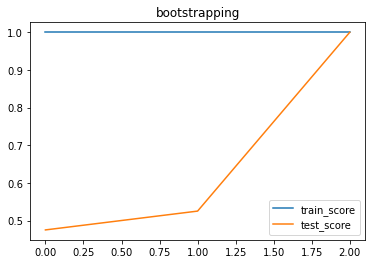

In [491]:

plt.plot(list(range(len(score_train))),score_train)
plt.plot(list(range(len(score_test))),score_test)
plt.title("bootstrapping")
plt.legend(["train_score","test_score"])
plt.show()

计算Hog,灰度图像必须是整数 ->Hog -> float32  ->SVM

In [492]:
aaaa = np.array([[1,1,1],[2,2,2],[3,3,3],[4,4,4]])
bbbb = np.array([[[1,1,1],[2,2,2],[3,3,3],[4,4,4]]])
'''np.random.shuffle 是按照数组的最高维度来打乱数据分布'''
np.random.shuffle(aaaa)
np.random.shuffle(bbbb)
aaaa,bbbb

(array([[1, 1, 1],
        [2, 2, 2],
        [3, 3, 3],
        [4, 4, 4]]),
 array([[[1, 1, 1],
         [2, 2, 2],
         [3, 3, 3],
         [4, 4, 4]]]))

In [493]:
'''测试 训练好的svm'''
dataset = np.concatenate((people,environments),axis=0)
predict = []
'''打乱数据集'''
np.random.shuffle(dataset)
for i,data in enumerate(dataset): #[0,9]
    feature_hog = Hog.compute(data,(16,16))
    feature_hog = feature_hog.reshape((1,18000))
    _,pre_0 = SVM_best.predict(feature_hog)
    predict.append(pre_0)

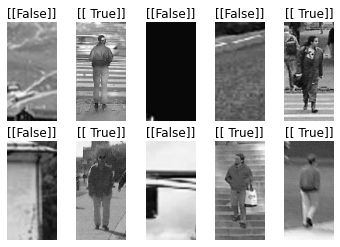

In [494]:
'''随机选择10个样本，显示数据与预测'''
for i,data in enumerate(dataset):
    plt.subplot(2,5,i+1)
    plt.title(f"{predict[i]==1}")
    plt.imshow(data,cmap='gray')
    plt.axis("off")


从上图,可以看见,经过bootstrapping SVM依据HOG特征检测行人的成功率 还是挺高的,这里没有交叉验证了.

bug：
TypeError: HOGDescriptor() takes at most 1 argument (2 given)
原因：opencv是基于c++/c开发的
    cv::Size是一个contains two integers的类。在pythonapi中，它表示为包含两个整数的元组。在
    因此，要在Python中调用此重载,只能输入元组与整数值,无法输入关键字例如
    hog = cv2.HOGDescriptor(winSize = (32,32),nbins = 1)
    元组：_winSize，_blockSize，_blockStride，和_cellSize 1x一个整数（对于_nbins)


TypeError: only size-1 arrays can be converted to Python scalars
    切片有误,一维数据还切  错误示范y[sd,：] ,解决办法.y[sd]



error: OpenCV(3.4.2) C:\Miniconda3\conda-bld\opencv-suite_1534379934306\work\modules\ml\src\svm.cpp:2010: error: (-215:Assertion failed) samples.cols == var_count && samples.type() == 5 in function 'cv::ml::SVMImpl::predict'
    原因：这意味着该样品或者不具有列的权数或不具有类型CV_32F.


error: (-215:Assertion failed) img.type() == 0 || img.type() == (((0) & ((1 << 3) - 1)) + (((3)-1) << 3)) in function 'cv::HOGDescriptor::computeGradient
    原因分析：将灰度图类型设置为了float32，所以发生了错误,或者是数据违反了第一个条件。为了应用svm，数据需要是一个向量，即1 x n矩阵。